<a href="https://colab.research.google.com/github/siting1206/NLP_HW1/blob/main/NER_Model_1030.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import namedtuple
from tensorflow.keras.preprocessing.sequence import pad_sequences

import regex as re
import os, string, sys

from gensim.models.word2vec import Word2Vec

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Preprocessing

In [121]:
class RegexFeatures(object):
    PATTERNS = {
        "repeatedPunctuation": re.compile(r'^[\.\,!\?"\':;_\-]{2,}$'),
        "isNumber": re.compile(r'^((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
        "isURL": re.compile(r'^http[s]?://'),
        "isMention": re.compile(r'^(RT)?@[\p{Alnum}_]+$'),
        "isHashtag": re.compile(r'^#\p{Alnum}+$'),
        "isMoney": re.compile(r'^\$((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
    }
    def __init__(self):
        print("Initialized RegexFeature")
    def process(word):
        features = dict()
        for k, p in RegexFeatures.PATTERNS.iteritems():
            if p.match(word):
                features[k] = True
        return features


Tag = namedtuple("Tag", ["token", "tag"])

def load_sequences(filename, sep="\t", notypes=False, test_data=False):
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
            line = line.strip()
            if line:
                line = line.split(sep)
                seq.append(Tag(*line))
            else:
                sequences.append(seq)
                seq = []
        if seq:
            sequences.append(seq)
    return sequences

def load_test_sequences(filename, sep="\t"):
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
          line = line.strip()
          if line:
            seq.append(line)
          else:
            sequences.append(seq)
            seq = []
        if seq:
          sequences.append(seq)
    return sequences

### Load Dataset

In [122]:
train_sequences = load_sequences("drive/MyDrive/NLP_assignment1/data/train.txt", sep="\t", notypes=True)
dev_sequences = load_sequences("drive/MyDrive/NLP_assignment1/data/dev.txt", sep="\t", notypes=False)
test_sequences = load_test_sequences("drive/MyDrive/NLP_assignment1/data/test-submit.txt", sep="\t")

In [123]:
train_sentences = [[t[0] for t in seq] for seq in (train_sequences)]
train_tags = [[t[1] for t in seq] for seq in (train_sequences)]

valid_sentences = [[t[0] for t in seq] for seq in (dev_sequences)]
valid_tags = [[t[1] for t in seq] for seq in (dev_sequences)]

# print(train_sentences)

In [124]:
other_entities = {
    "isHashtag": [],
    "isMention": [],
    "isURL": [],
    "isMoney": [],
    "isNumber": [],
    "repeatedPunctuation": []
}
for seq in train_sentences:
    for t in seq:
        for k in other_entities.keys():
            if RegexFeatures.PATTERNS[k].match(t):
                other_entities[k].append(t)
for k, v in other_entities.items():
    print(k, len(v))

isHashtag 440
isMention 1292
isURL 448
isMoney 5
isNumber 120
repeatedPunctuation 1059


In [125]:
ENTITY_MAPPINGS={k: "__%s__" % k for k in other_entities.keys()}
ENTITY_MAPPINGS

{'isHashtag': '__isHashtag__',
 'isMention': '__isMention__',
 'isURL': '__isURL__',
 'isMoney': '__isMoney__',
 'isNumber': '__isNumber__',
 'repeatedPunctuation': '__repeatedPunctuation__'}

In [126]:
def preprocess_token(x, to_lower=False):
    for k in ENTITY_MAPPINGS.keys():
        if RegexFeatures.PATTERNS[k].match(x):
            return ENTITY_MAPPINGS[k]
    if to_lower:
        x = x.lower()
    return x

#### For the input of LSTM model all the sentences must be padded to same length,for that we must know the maximum length of the sequence in the list of sentences.

In [127]:
train_pre_seq = [[preprocess_token(t[0], to_lower=False) for t in seq] for seq in train_sequences]
dev_pre_seq = [[preprocess_token(t[0], to_lower=False) for t in seq] for seq in dev_sequences]
test_pre_seq = [[preprocess_token(t, to_lower=False) for t in seq] for seq in test_sequences]

In [128]:
word2vec_sentences = [preprocess_token(t[0], to_lower=False) for seq in train_sequences for t in seq]
testtt = [preprocess_token(t, to_lower=False) for seq in test_sequences for t in seq]
tag2vec_sentences = [t[1] for seq in train_sequences for t in seq]
words=list(set(word2vec_sentences))
# print(word2vec_sentences)
tags=list(set(tag2vec_sentences))
# print(tags)
w_index={t:j for j,t in enumerate(words)}
t_index={t:j+1 for j,t in enumerate(tags)}
print(t_index)
n_words = len(w_index)
n_tags = len(t_index)
y_train = [[t_index[w[1]] for w in s] for s in train_sequences]
y_valid = [[t_index[w[1]] for w in s] for s in dev_sequences]

{'B-person': 1, 'B-movie': 2, 'I-geo-loc': 3, 'B-company': 4, 'O': 5, 'I-movie': 6, 'B-musicartist': 7, 'B-facility': 8, 'I-facility': 9, 'I-tvshow': 10, 'I-product': 11, 'I-sportsteam': 12, 'I-company': 13, 'B-product': 14, 'B-sportsteam': 15, 'B-other': 16, 'I-person': 17, 'B-tvshow': 18, 'B-geo-loc': 19, 'I-other': 20, 'I-musicartist': 21}


In [129]:
train_maxl = max([len(s) for s in train_pre_seq])
dev_maxl = max([len(s) for s in dev_pre_seq])
# print ('Maximum length in the list of train_sentences:', train_maxl)
# print ('Maximum length in the list of dev_sentences:', dev_maxl)
maxl = max(train_maxl, dev_maxl)

In [130]:
word2vec_sentences[0]

'__isMention__'

In [131]:
preprocess_token("@guild_gamer")

'__isMention__'

### Word2Vec Model

In [132]:
word2vec = Word2Vec(train_pre_seq + dev_pre_seq, size=50, window=10, sg=1, hs=0, min_count=1, negative=5, workers=1, iter=5)
print(word2vec)

Word2Vec(vocab=11298, size=50, alpha=0.025)


In [133]:
embedding_matrix = word2vec.wv.vectors
print(embedding_matrix.shape)
embedding_matrix = np.vstack((np.array(np.zeros(50)), embedding_matrix))
embedding_matrix.shape
# [word2vec.wv.vocab[sen].index for sen in train_pre_seq[0]]

(11298, 50)


(11299, 50)

In [134]:
X_train = np.zeros([len(train_pre_seq), maxl], dtype='float32')
for i in range(len(train_pre_seq)):
  for j in range(min(len(train_pre_seq[i]),maxl)):
    X_train[i,j] = word2vec.wv.vocab[train_pre_seq[i][j]].index
    
X_valid = np.zeros([len(dev_pre_seq), maxl], dtype='float32')
for i in range(len(dev_pre_seq)):
  for j in range(min(len(dev_pre_seq[i]),maxl)):
    X_valid[i,j] = word2vec.wv.vocab[dev_pre_seq[i][j]].index

In [135]:
from keras.utils import to_categorical
y_train = pad_sequences(maxlen=maxl, padding='post', sequences=y_train)
y_train = to_categorical(y_train) # (2394,41)->(2394,41,22)
print(X_train.shape, y_train.shape)

y_valid = pad_sequences(maxlen=maxl, padding='post', sequences=y_valid)
y_valid = to_categorical(y_valid) # (1000,41)->(1000,41,22)
print(X_valid.shape, y_valid.shape)

(2394, 41) (2394, 41, 22)
(1000, 41) (1000, 41, 22)


### Model

In [136]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [137]:
input=Input(shape=maxl)
model=Embedding(len(word2vec.wv.vocab)+1, 50)(input)
model=SpatialDropout1D(0.1)(model)
model=Bidirectional(LSTM(units=150,return_sequences=True, recurrent_dropout=0.1))(model)
output = TimeDistributed(Dense(n_tags+1, activation="softmax"))(model)

In [138]:
model=Model(input,output)

In [139]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 41)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 41, 50)            564950    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 41, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 41, 300)          241200    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 41, 22)           6622      
 tributed)                                                       
                                                           

In [148]:
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable=True
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 41)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 41, 50)            564950    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 41, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 41, 300)          241200    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 41, 22)           6622      
 tributed)                                                       
                                                           

In [149]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [142]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [143]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

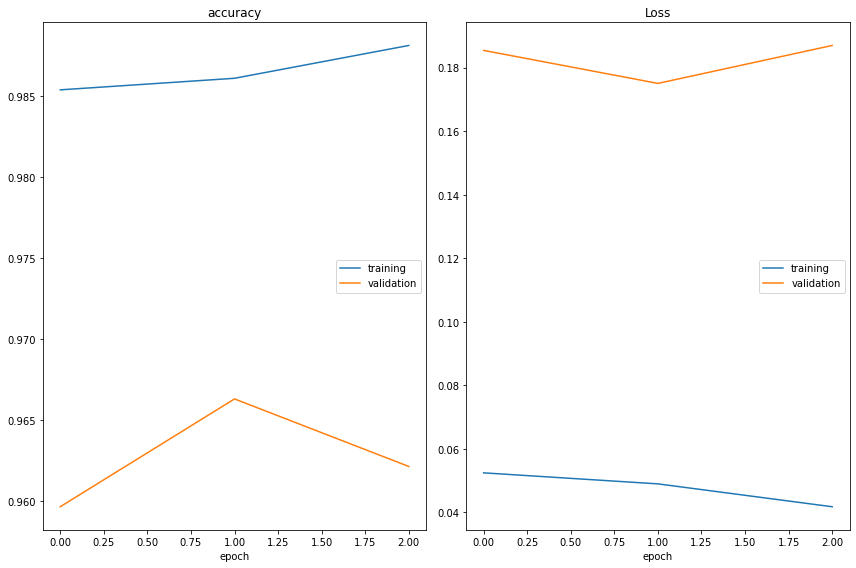

accuracy
	training         	 (min:    0.985, max:    0.988, cur:    0.988)
	validation       	 (min:    0.960, max:    0.966, cur:    0.962)
Loss
	training         	 (min:    0.042, max:    0.052, cur:    0.042)
	validation       	 (min:    0.175, max:    0.187, cur:    0.187)
75/75 [==============================] - 13s 173ms/step - loss: 0.0417 - accuracy: 0.9881 - val_loss: 0.1870 - val_accuracy: 0.9621


In [160]:
early_stop= EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks=[PlotLossesCallback(),early_stop]
history=model.fit(X_train,np.array(y_train), validation_data=(X_valid, np.array(y_valid)), batch_size=32, epochs=10, verbose=1, callbacks=callbacks)

In [161]:
model.evaluate(X_train,np.array(y_train))

75/75 [==============================] - 2s 25ms/step - loss: 0.0349 - accuracy: 0.9905


[0.03487981855869293, 0.9904741644859314]

In [163]:
p = model.predict(np.array([X_valid[1]]))
p = np.argmax(p, axis=-1)
print(t_index)
print(p)

1/1 [==============================] - 0s 23ms/step
{'B-person': 1, 'B-movie': 2, 'I-geo-loc': 3, 'B-company': 4, 'O': 5, 'I-movie': 6, 'B-musicartist': 7, 'B-facility': 8, 'I-facility': 9, 'I-tvshow': 10, 'I-product': 11, 'I-sportsteam': 12, 'I-company': 13, 'B-product': 14, 'B-sportsteam': 15, 'B-other': 16, 'I-person': 17, 'B-tvshow': 18, 'B-geo-loc': 19, 'I-other': 20, 'I-musicartist': 21}
[[ 5  5  5  5  5  5 20 20  5  5  5  5  5  5  5  5  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
